In [1]:
import numpy as np
import pandas as pd
import os, random, glob, cv2, gc
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from termcolor import colored

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from albumentations import Compose, Normalize, HorizontalFlip, VerticalFlip

In [2]:
torch.cuda.empty_cache()
gc.collect()

31

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [4]:
class config:
    IMG_HEIGHT = 512
    IMG_WIDTH = 512
    BS = 16

# Data

In [5]:
df = pd.read_csv('train.csv').set_index('image_id')

In [6]:
# shuffle
df = shuffle(df)


# split
train_df, val_df = train_test_split(df, test_size=0.2)
val_df, test_df = train_test_split(val_df, test_size=0.2)

train_df = train_df.reset_index()
val_df = val_df.reset_index()
test_df = test_df.reset_index()

print(len(train_df), len(val_df), len(test_df))

8492 1699 425


In [7]:
train_df.head()

,image_id,data_provider,isup_grade,gleason_score
0,e976c3cf104dcc86cee5a69421bb38b4,karolinska,0,0+0
1,8fa7f6ad508c78ef7dbd621d579350b8,radboud,3,4+3
2,9b7a3bed1f74654040a37290572015c5,radboud,0,negative
3,204a1ddef1580e571872b2d4e424b4fe,radboud,2,3+4
4,43d1869ae02754e6a5fd2ff02ebab94c,karolinska,1,3+3


# Augmentation

In [8]:
mean = [1-0.90949707, 1-0.8188697, 1-0.87795304]
std = [0.36357649, 0.49984502, 0.40477625]
train_transforms = Compose([HorizontalFlip(p=0.5), 
                            VerticalFlip(p=0.5),
                            Normalize(mean, std)])
val_transforms = Compose([Normalize(mean, std)])

# Dataset

In [9]:
class MyDataset(Dataset):
    def __init__(self, df, split='train'):
        super().__init__()
        self.dir = './pandatiled/'
        self.df = df
        self.split = split
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name = self.df.image_id[idx]
        path = os.path.join(self.dir, name+'.png')
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (config.IMG_HEIGHT, config.IMG_WIDTH))
        if self.split == 'train':
            img = train_transforms(**{'image': img})['image']
        elif self.split == 'val':
            img = val_transforms(**{'image': img})['image']
        img = torch.tensor(img).permute(2, 0, 1)
        
        label = torch.tensor(self.df.isup_grade[idx])
        return img, label
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512])


Text(0.5, 1.0, 'tensor(0)')

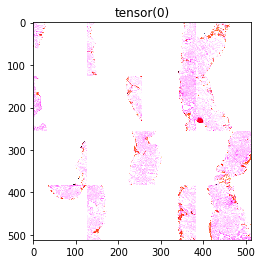

In [10]:
# test dataset
train_ds = MyDataset(train_df, 'train')
x, y = train_ds[2]
print(x.shape)
plt.imshow(x.permute(1, 2, 0).numpy())
plt.title(y)

In [26]:
train_ds = MyDataset(train_df, 'train')
train_dl = DataLoader(train_ds, batch_size=config.BS, shuffle=True) # use 32 means 2 images per batch, don't shuffle to preserve 

val_ds = MyDataset(val_df, 'val')
val_dl = DataLoader(val_ds, batch_size=config.BS, shuffle=False)

test_ds = MyDataset(test_df, 'val')
test_dl = DataLoader(test_ds, batch_size=config.BS, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'tensor(1)')

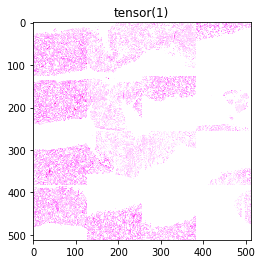

In [27]:
# test dl
x, y = next(iter(train_dl))
plt.imshow(x[0].permute(1, 2, 0).numpy())
plt.title(y[0])

# Model

In [28]:
from collections import OrderedDict
import math


class SEModule(nn.Module):

    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x


class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se_module(out) + residual
        out = self.relu(out)

        return out


class SEBottleneck(Bottleneck):
    """
    Bottleneck for SENet154.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.conv2 = nn.Conv2d(planes * 2, planes * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.conv3 = nn.Conv2d(planes * 4, planes * 4, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNetBottleneck(Bottleneck):
    """
    ResNet bottleneck with a Squeeze-and-Excitation module. It follows Caffe
    implementation and uses `stride=stride` in `conv1` and not in `conv2`
    (the latter is used in the torchvision implementation of ResNet).
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False,
                               stride=stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1,
                               groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNeXtBottleneck(Bottleneck):
    """
    ResNeXt bottleneck type C with a Squeeze-and-Excitation module.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None, base_width=4):
        super(SEResNeXtBottleneck, self).__init__()
        width = math.floor(planes * (base_width / 64)) * groups
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False,
                               stride=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SENet(nn.Module):

    def __init__(self, block, layers, groups, reduction, dropout_p=0.2,
                 inplanes=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000):
        super(SENet, self).__init__()
        self.inplanes = inplanes
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1,
                                    bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, inplanes, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn3', nn.BatchNorm2d(inplanes)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, inplanes, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(inplanes)),
                ('relu1', nn.ReLU(inplace=True)),
            ]
        # To preserve compatibility with Caffe weights `ceil_mode=True`
        # is used instead of `padding=1`.
        layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,
                                                    ceil_mode=True)))
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(
            block,
            planes=64,
            blocks=layers[0],
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=1,
            downsample_padding=0
        )
        self.layer2 = self._make_layer(
            block,
            planes=128,
            blocks=layers[1],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer3 = self._make_layer(
            block,
            planes=256,
            blocks=layers[2],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer4 = self._make_layer(
            block,
            planes=512,
            blocks=layers[3],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.avg_pool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, groups, reduction, stride=1,
                    downsample_kernel_size=1, downsample_padding=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, groups, reduction, stride,
                            downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups, reduction))

        return nn.Sequential(*layers)

    def features(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, x):
        x = self.avg_pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x


def initialize_pretrained_model(model, num_classes, settings):
    assert num_classes == settings['num_classes'], \
        'num_classes should be {}, but is {}'.format(
            settings['num_classes'], num_classes)
    model.load_state_dict(model_zoo.load_url(settings['url']))
    model.input_space = settings['input_space']
    model.input_size = settings['input_size']
    model.input_range = settings['input_range']
    model.mean = settings['mean']
    model.std = settings['std']


def se_resnext50_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = config.pretrained_settings['se_resnext50_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext101_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 23, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = config.pretrained_settings['se_resnext101_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model

In [29]:
class CustomSEResNeXt(nn.Module):

    def __init__(self, model_name='se_resnext50_32x4d'):
        assert model_name in ('se_resnext50_32x4d')
        super().__init__()
        
        self.model = se_resnext50_32x4d(pretrained=None)
        self.model.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.model.last_linear = nn.Linear(self.model.last_linear.in_features, 6)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [30]:
model = CustomSEResNeXt(model_name='se_resnext50_32x4d')
_ = model.to(device)
model.load_state_dict(torch.load('./seresnet50-6.pth', map_location=device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.) # traditional lr
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, verbose=1)

In [31]:
# freeze 
# def freeze_until(model, name):
#     flag = False
#     for n, p in model.named_parameters():
#         if n == name:
#             flag = True
#         p.requires_grad = flag
# freeze_until(model, 'model.layer4.2.conv1.weight')

In [32]:
x = torch.tensor(np.random.randn(12, 3, 512, 512)).to(device).float()
print(model(x).shape)
del x

torch.Size([12, 6])


# Training

In [33]:
cohen_prev = np.ones(len(train_dl)) + 1

def train_on(epoch):
    # 
    torch.cuda.empty_cache()
    gc.collect()
    
    model.train(True)
    
    loss_epoch = []
    acc_epoch = []
    cohen_epoch = []
    cohen = None
    for i, (x, y) in tqdm(enumerate(train_dl), total=len(train_dl)):
        x = x.to(device)
        y = y.to(device)
        j = 0 # extra 
        
        # cohen is None: first
        # cohen < 0.6: not satisfied
        while cohen is None :
            y_preds = model(x)

            # get metrics
            loss = nn.CrossEntropyLoss()(y_preds, y)
            acc = accuracy_score(y_preds.argmax(axis=1).cpu().detach().numpy() , y.cpu().detach().numpy() )
            cohen = cohen_kappa_score(y_preds.argmax(axis=1).cpu().detach().numpy() , y.cpu().detach().numpy() , weights='quadratic')

            # update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
#             j += 1
#             print('-------Extra: %d, Cohen: %2f' % (j, cohen))
        
            
        # print
#         if cohen_prev[i] == 2:
#             print('Epoch: %d, Step: %d, Loss: %2f, Acc: %2f, Cohen: %2f' % (epoch, i, loss, acc, cohen))
#         elif cohen > cohen_prev[i]:
#             print(colored('Epoch: %d, Step: %d, Loss: %2f, Acc: %2f, Cohen: %2f' % (epoch, i, loss, acc, cohen), 'green'))
#         elif cohen <= cohen_prev[i]:
#             print(colored('Epoch: %d, Step: %d, Loss: %2f, Acc: %2f, Cohen: %2f' % (epoch, i, loss, acc, cohen), 'red'))
#         cohen_prev[i] = cohen
        
        
        loss_epoch.append(loss.cpu().detach().numpy())
        acc_epoch.append(acc)
        cohen_epoch.append(cohen)
        
        
        # clean
        del x, y, y_preds, loss, acc, cohen
        torch.cuda.empty_cache()
        gc.collect()
        cohen = None; j = 0
        
    print(np.array(loss_epoch).mean(), np.array(acc_epoch).mean(), np.array(cohen_epoch).mean())
    return np.array(loss_epoch).mean(), np.array(acc_epoch).mean(), np.array(cohen_epoch).mean()
        

In [34]:
cohen_val_prev = np.ones(len(val_dl)) + 1

def val_on(epoch, dl):
    # 
    torch.cuda.empty_cache()
    gc.collect()
    
    model.eval()
    
    loss_epoch = []
    acc_epoch = []
    cohen_epoch = []
    cohen = None
    for i, (x, y) in tqdm(enumerate(dl), total=len(dl)):
        with torch.no_grad():
            x = x.to(device)
            y = y.to(device)
            
            y_preds = model(x)

            # get metrics
            loss = nn.CrossEntropyLoss()(y_preds, y)
            acc = accuracy_score(y_preds.argmax(axis=1).cpu().detach().numpy() , y.cpu().detach().numpy() )
            cohen = cohen_kappa_score(y_preds.argmax(axis=1).cpu().detach().numpy() , y.cpu().detach().numpy() , weights='quadratic')

            
            # print
#             if cohen_val_prev[i] == 2:
#                 print('Epoch: %d, Step: %d, Loss: %2f, Acc: %2f, Cohen: %2f' % (epoch, i, loss, acc, cohen))
#             elif cohen > cohen_val_prev[i]:
#                 print(colored('Epoch: %d, Step: %d, Loss: %2f, Acc: %2f, Cohen: %2f' % (epoch, i, loss, acc, cohen), 'green'))
#             elif cohen <= cohen_val_prev[i]:
#                 print(colored('Epoch: %d, Step: %d, Loss: %2f, Acc: %2f, Cohen: %2f' % (epoch, i, loss, acc, cohen), 'red'))
#             cohen_val_prev[i] = cohen
        
        
            loss_epoch.append(loss.cpu().detach().numpy())
            acc_epoch.append(acc)
            cohen_epoch.append(cohen)
        
        
            # clean
            del x, y, y_preds, loss, acc, cohen
            torch.cuda.empty_cache()
            gc.collect()
        
    print(np.array(loss_epoch).mean(), np.array(acc_epoch).mean(), np.array(cohen_epoch).mean())
    return np.array(loss_epoch).mean(), np.array(acc_epoch).mean(), np.array(cohen_epoch).mean()
        
            

In [37]:
def train(epochs):
    best_cohen = []
    for e in range(epochs):
        train_loss, train_acc, train_cohen = train_on(e)
        val_loss, val_acc, val_cohen = val_on(e, val_dl)
        
        scheduler.step(val_loss)
        
        # save best
        best_cohen.append(val_cohen)
        if val_cohen >= max(best_cohen):
            print('save best model')
            torch.save(model.state_dict(), 'seresnetxt.pth')

In [ ]:
train(10)

In [ ]:
val_on(1, val_dl)

In [ ]:
val_on(1, test_dl)

In [ ]:
!ls

In [ ]:
torch.save(model.state_dict(), './efn.pth')

In [ ]:
from IPython.display import FileLink
FileLink('./seresnetxt.pth')